In [1]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data
import numpy as np
import torch.nn.functional as F
from model import Model
import easydict
import torch.nn as nn
global opt
from utils import CTCLabelConverter, CTCLabelConverterForBaiduWarpctc, AttnLabelConverter, Averager
import modules
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

global opt

opt = easydict.EasyDict({
    "exp_name": "test_01",
    "train_data": "/data/data/STARN/data_lmdb_release/training",
    "valid_data":"/data/data/STARN/data_lmdb_release/validation",
    "manualSeed": 1111,
    "workers": 8,
    "batch_size":1024,
    "num_iter":300000,
    "valInterval":1,
    "saved_model":'',
    "FT":False,
    "adam":False,
    "lr":1,
    "beta1":0.9,
    "rho":0.95,
    "eps":1e-8,
    "grad_clip":5,
    "baiduCTC":False,
    "select_data":'ST',
    "batch_ratio":'1',
    "total_data_usage_ratio":'1.0',
    "batch_max_length":25,
    "imgW":100,
    "imgH":32,
    "rgb":False,
    "character":"0123456789abcdefghijklmnopqrstuvwxyz",
    "sensitive":False,
    "PAD":False,
    "data_filtering_off":False,
    "Transformation":"TPS",
    "FeatureExtraction":"ResNet",
    "SequenceModeling":"BiLSTM",
    "Prediction":'Attn',
    "num_fiducial":20,
    "input_channel":1,
    "output_channel":512,
    "hidden_size":256    
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "cpu"

numclass_path = "./ch_range.txt"
f = open(numclass_path, 'r')
ch_temp = f.read()
f.close()


opt.character = ch_temp

converter = AttnLabelConverter(opt.character)
opt.num_class = len(converter.character)

model = Model(opt)

model.load_state_dict(torch.load("./single.pt"))
model = model.to(device)
print(model)



Model(
  (Transformation): TPS_SpatialTransformerNetwork(
    (LocalizationNetwork): LocalizationNetwork(
      (conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): ReLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (10): ReLU(inplace=True)
        (11): MaxPool2d(kernel_size=2, 

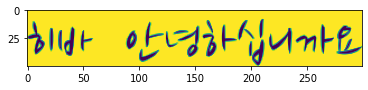

(299, 50)
torch.Size([1, 1, 32, 100])


In [2]:
# read and visualize an image
img = Image.open("./1. 데이터 관련 test/1.png").convert('L')
plt.imshow(img)
plt.show()
print(img.size)

# define the transforms
transform = transforms.Compose([
    transforms.Resize((32, 100)),
    transforms.ToTensor(),
])


img = transform(img)
img = img.to(device)

# unsqueeze to add a batch dimension
img = img.unsqueeze(0)
print(img.size())

In [3]:
model_children = list(model.children())

network_stage = []
## 가져올 목록
for i in range(len(model_children)):
    network_stage.append(model_children[i])



## 첫번째 스테이지 TPS 
results = [network_stage[0](img)]


## 두번째 스테이지 ResNet50 - 피쳐맵 뽑기
results.append(network_stage[1](results[-1]))


## 세번째 스테이지 AdaptiveAvgPool
## 일종의 리쉐이프+풀링
# 풀링 모듈 선언
# [b, c, h, w] -> [b, w, c, h]
# print(results[-1].shape)
# print(results[-1].permute(0, 3, 1, 2).shape)
results[-1]=results[-1].permute(0, 3, 1, 2)
# print(results[-1].shape)
results.append(network_stage[2](results[-1]) )
print(results[-1].shape)



print(results[-1].squeeze(3).shape)
# ## 네번째 스테이지 BI-LSTM
results[-1] =results[-1].squeeze(3)
results.append(network_stage[3](results[-1]))
# # print(results[-1].shape)


## 다섯번쨰 어텐션은 나중에 따로


outputs = results

torch.Size([1, 26, 512, 1])
torch.Size([1, 26, 512])


In [ ]:
for i in range(0,len(outputs)):
    print(outputs[i].shape)

##  1~3번은 이미지 출력을 위해 채널을 변경해줘야함
outputs[1]=outputs[1].permute(0, 2, 3, 1) 
outputs[2]=outputs[2].permute(0, 2,1) 
outputs[3]=outputs[3].permute(0,2,1) 



In [ ]:
## 스테이지 이름만 추출
stage_name = list(model.named_children())
for i in range(0,len(stage_name)):
    start_c = str(stage_name[i]).find("'")
    end_c = str(stage_name[i]).find("'",start_c+1)
    stage_name[i] = str(stage_name[i])[start_c+1:end_c]

print(stage_name)


In [ ]:


for stage in range(0,len(outputs)):
    plt.figure(figsize=(25, 25),dpi=150)
#     layer_viz = outputs[stage][0, :, :, :]
    
    if len(outputs[stage].shape)==4:
        layer_viz = outputs[stage][0, :, :, :]
    elif len(outputs[stage].shape)==3:
        layer_viz = outputs[stage][0, :, :]
#     elif len(outputs[stage].shape)==2:
#         layer_viz = outputs[stage][0, :]
#     elif len(outputs[stage].shape)==1:
#         layer_viz = outputs[stage][:]
        
    layer_viz = layer_viz.data
    layer_viz = layer_viz.to("cpu")
    print(layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # 특징맵을 일단 최대 64개까지만 출력함 -> 다 출력 해봤자 해석 불가함
            break
        plt.subplot(8, 8, i + 1)
        plt.title(stage_name[stage]+"_"+str(i))

        ## 차원이 1이라면 강제로 차원을 늘림
        if len(filter.shape)==1:
            filter=  filter.unsqueeze(0)
            
        plt.imshow(filter, cmap='jet')
        plt.axis("off")
    print(f"Saving layer {stage} feature maps...")
    plt.savefig(f"./layer_f_image/{stage}.{stage_name[stage]}.png")
    # plt.show()
    plt.close()

In [ ]:
print(outputs[2].shape)
print(stage_name[2])

In [ ]:
"""
Copyright (c) 2019-present NAVER Corp.
Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
    http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""


import torch.nn as nn

from modules.transformation import TPS_SpatialTransformerNetwork
from modules.feature_extraction import VGG_FeatureExtractor, RCNN_FeatureExtractor, ResNet_FeatureExtractor
from modules.sequence_modeling import BidirectionalLSTM
from modules.prediction import Attention


class Model(nn.Module):

    def __init__(self, opt):
        super(Model, self).__init__()
        self.opt = opt
        self.stages = {'Trans': opt.Transformation, 'Feat': opt.FeatureExtraction,
                       'Seq': opt.SequenceModeling, 'Pred': opt.Prediction}

        """ Transformation """
        if opt.Transformation == 'TPS':
            self.Transformation = TPS_SpatialTransformerNetwork(
                F=opt.num_fiducial, I_size=(opt.imgH, opt.imgW), I_r_size=(opt.imgH, opt.imgW), I_channel_num=opt.input_channel)
        else:
            print('No Transformation module specified')

        """ FeatureExtraction """
        if opt.FeatureExtraction == 'VGG':
            self.FeatureExtraction = VGG_FeatureExtractor(opt.input_channel, opt.output_channel)
        elif opt.FeatureExtraction == 'RCNN':
            self.FeatureExtraction = RCNN_FeatureExtractor(opt.input_channel, opt.output_channel)
        elif opt.FeatureExtraction == 'ResNet':
            self.FeatureExtraction = ResNet_FeatureExtractor(opt.input_channel, opt.output_channel)
        else:
            raise Exception('No FeatureExtraction module specified')
        self.FeatureExtraction_output = opt.output_channel  # int(imgH/16-1) * 512
        self.AdaptiveAvgPool = nn.AdaptiveAvgPool2d((None, 1))  # Transform final (imgH/16-1) -> 1

        """ Sequence modeling"""
        if opt.SequenceModeling == 'BiLSTM':
            self.SequenceModeling = nn.Sequential(
                BidirectionalLSTM(self.FeatureExtraction_output, opt.hidden_size, opt.hidden_size),
                BidirectionalLSTM(opt.hidden_size, opt.hidden_size, opt.hidden_size))
            self.SequenceModeling_output = opt.hidden_size
        else:
            print('No SequenceModeling module specified')
            self.SequenceModeling_output = self.FeatureExtraction_output

        """ Prediction """
        if opt.Prediction == 'CTC':
            self.Prediction = nn.Linear(self.SequenceModeling_output, opt.num_class)
        elif opt.Prediction == 'Attn':
#             print("프리딕션부터 선언됨")
            self.Prediction = Attention(self.SequenceModeling_output, opt.hidden_size, opt.num_class)
        else:
            raise Exception('Prediction is neither CTC or Attn')

    def forward(self, input, text, is_train=True):
        """ Transformation stage """
        if not self.stages['Trans'] == "None":
            input = self.Transformation(input)
#         print("FE 전 쉐이프")
#         print(visual_feature.shape)
        
           
            
        """ Feature extraction stage """
        visual_feature = self.FeatureExtraction(input)
        visual_feature = self.AdaptiveAvgPool(visual_feature.permute(0, 3, 1, 2))  # [b, c, h, w] -> [b, w, c, h]
#         print("스퀴즈 전")
#         print(visual_feature.shape)
        # torch.Size([768, 26, 512, 1])

#         ## 3번째 차원을 날림, h는 에버리지 풀링후 크기가 1 
        visual_feature = visual_feature.squeeze(3)
#         print("스퀴즈 후")
#         print(visual_feature.shape)
#         torch.Size([768, 26, 512])

        
        """ Sequence modeling stage """
        if self.stages['Seq'] == 'BiLSTM':
            contextual_feature = self.SequenceModeling(visual_feature)
        else:
            contextual_feature = visual_feature  # for convenience. this is NOT contextually modeled by BiLSTM
        
        ## 컨텍스트 
#         print(contextual_feature.shape)
#         torch.Size([768, 26, 256])
        
        """ Prediction stage """
        if self.stages['Pred'] == 'CTC':
            prediction = self.Prediction(contextual_feature.contiguous())
        else:
            ## 어텐션 포워드로 들어감
            # print(contextual_feature.shape)
            # torch.Size([768, 26, 256]) 배치사이즈 * 문자열 최대길이+1 * bilstm 아웃풋 256
            print(type(text))
            print(type(is_train))
            prediction = self.Prediction(contextual_feature.contiguous(), text, is_train, batch_max_length=self.opt.batch_max_length)

        return prediction
